Evaluation of Amazon Transcribe 

This notebook contains the analysis of performance of Amazon Transcribe service. The evaluations is done based on the dataset collected by *Descript* available aat https://airtable.com/appvWk23jLudQRWKu/shr1BF9rWJsTE70zZ/tblwP2dpg02WHUA4B/viw79dPwj3BlbsKSi?blocks=hide. 

The notebook consists of 3 parts:
* data collection
* transcribing and evaluating base 
* transcribing and evaluating with potentially improved approach.

In [323]:
# import pandas as pd
# import boto3
# import logging
# from botocore.exceptions import ClientError
# import json
# from datetime import datetime
# import re
# import time
# import os
# import csv
# from typing import List
from transcribing_job import *
from utilities import *
import matplotlib.pyplot as plt
import seaborn as sns

## Data collection and analysis

As the response call to access the table using html was rejected (both using request library and airtable API) and the table isn't huge (consists of 46 samples with youtube links), it was collected by hand. The audios were downloaded using inspector and network links which were then stored locally. This way all audio samples were available for analysis despite some of the links were no longer available on *YouTube*. The timestamps were collected based on *YouTube* transcription service. Because of the requirements for this task an additional youtube_download.py script was created (although the audios were already available locally). All audio files were names by the Id from dataset and the audio extension. 

In [286]:
df = pd.read_csv('data/samples.csv')
display(df.head())
df.shape

,Id,Tags,Youtube Link,Reference Transcript,Title,Duration,Start,Availability
0,1,Unscripted Broadcast,https://www.youtube.com/watch?v=9HPshG5IlcI,"\nLet's bring in Phil Mackie, who is there at ...",Trump arrives at Blenheim Palace - BBC News,04:57,00:45,True
1,2,Unscripted Broadcast,https://www.youtube.com/watch?v=qmgVQlSzYhw,We are getting reports that 11 people have bee...,Thailand Cave rescue: '11th person brought out...,05:04,00:00,True
2,3,Unscripted Broadcast,https://www.youtube.com/watch?v=E2h4-I2OLgA,I know that it's something you want to talk ab...,Money Clinic: Miami - BBC News,04:55,03:30,True
3,4,Unscripted Broadcast,https://www.youtube.com/watch?v=jRJyyLcKf1g,Someone who will be committed to rolling back ...,Sen. Warren: President Donald Trump SCOTUS Nom...,04:58,03:37,True
4,5,Unscripted Broadcast,https://www.youtube.com/watch?v=az9td4mARt0,While President Trump weighs his Supreme Court...,Gorka: Dems Upset Over SCOTUS Pick Because It ...,05:00,00:00,True


(46, 8)

Let's check how many of those audios are still available on *YouTube*. And inspect the tags.

In [5]:
df['Availability'].value_counts()

Availability
True     38
False     8
Name: count, dtype: int64

Using the network from inspector we were able to collect 8 more samples that are not available.

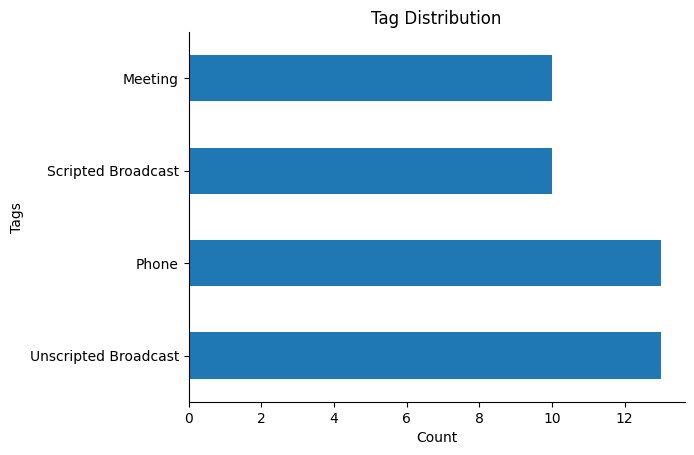

In [291]:
df['Tags'].value_counts().plot(kind='barh')
plt.title("Tag Distribution")
plt.xlabel('Count')
sns.despine()

The categories of audio had samples with a variety of different speakers (including some with accents), pace and topic discussed. There are 13 samples from phone and unscripted broadcast and 10from scripted broadcast and meetings.

* Scripted broadcast (like news anchors reading from teleprompters, and audiobook recordings)
* Unscripted broadcast (like podcasts, and TV interview/debate shows)
* Telephone and VoIP calls
* Meetings


Through the text analysis there were some changes made to the reference transcript as: 
* addition of one sentence in the end in sample 26
* some minor mistakes in were the space should be placed
* replacement of wrong letteres.

Let's see the lengths of the audios.

In [306]:
df['Duration'].apply(lambda x: datetime.strptime(x, "%M:%S")).describe()


count                               46
mean     1900-01-01 00:04:45.282608896
min                1900-01-01 00:01:54
25%                1900-01-01 00:04:50
50%         1900-01-01 00:04:56.500000
75%                1900-01-01 00:05:00
max                1900-01-01 00:05:15
Name: Duration, dtype: object

The shortest clip has almost 2 mins and the longest just above 5 mins. Most of the clips are close to 5 mins which makes almost 230min of audio to transcribe.

If we wouldn't have the audio data we would run the below cell.

In [299]:
# from youtube_download import download_yt_audio
# from utilities import change_to_seconds 

# # Get needed columns
# download_col = ['Id', 'Youtube Link', 'Duration', 'Start']
# df_yt = df[download_col].loc[df['Availability']==True]
# df_yt['Start Seconds'] = df_yt['Start'].map(change_to_seconds)
# df_yt['End Seconds'] = df_yt['Duration'].map(change_to_seconds) + df_yt['Start Seconds']

# # Prepare variables
# urls = df_yt['Youtube Link'].tolist()
# file_names = [str(id) + ".mp4" for id in df_yt['Id'].tolist()]
# starts = df_yt['Start Seconds'].tolist()
# ends = df_yt['End Seconds'].tolist()
# output_folder = 'audios'

# download_yt_audio(urls, file_names, starts, ends, output_folder)


Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join

## Transcription job and analysis of results

### Transcription

For the first run we will:
* get the access at the specified region
* initialize S3 and Amazon Transcribe Client
* initialize bucket with a given name
* load the samples from a given location to the folder with specified name
* perform transcription and store the output in specified folder in the bucket
* load the json files to specified location locally
* create csv file with id and output

In [ ]:
region = 'eu-west-2'
access_file = "gosiak_accessKeys.csv"
access_key, secret_key = get_access_credentials(access_file)
access = {'aws_access_key_id': access_key, 
          'aws_secret_access_key': secret_key, 
          'region_name': region}
s3_client =  boto3.client('s3', **access)
transcribe_client = boto3.client('transcribe', **access)

In [36]:
bucket_name = 'turingcollegebiomapas'
input_folder = 'data/mp3/'
output_folder = 'transcriptions/'
transcribe_csv = 'data/transcript.csv'
version = "A"  
format = "m4a"
lang_code = 'en-US'

In [318]:
check_assertions(input_folder, output_folder, version, format)

In [26]:
create_bucket(s3_client, bucket_name, region)
folder_upload(s3_client, bucket_name, input_folder)
job_count = transcribe_folder(s3_client, transcribe_client, bucket_name, 
                  input_folder, output_folder, lang_code, format, version)
download_folder(s3_client, bucket_name, output_folder, job_count)
transcripts_to_csv(output_folder, transcribe_csv)

   Id                                  Amazon Transcript
0   1  Let's bring in Phil Mackie who is uh there at ...
1  10  Do you think Mr lebron James will be patient e...
2  11  Where does James Harden rank as a player? Not ...
3  12  Welcome to the Undisputed podcast. I'm your ho...
4  13  Right now, guys, start your website that you a...


### Assesment of results
To assess the performance we will use two metrics: 
* Word Error Rate which is define as WER = insertions + deletion + substitutions/ number of words in the reference
* Character Error Rate with does the same but taking into characters

With both metrics we face a problem of treating each word, letter with the same weight although some can have same meaning and shouldn't be counted into an error.
We will take some measures to adjust normalization to the extend the comparison in reasonable.

We will also take into account information from https://blog.timbunce.org/2017/02/09/comparing-transcriptions/ that Word Error Rate for human transcript is around 5.



Before the comparison of text we need to perform a few transformations to normalize ground true and transcriptions: 
* remove:
    * laughing sound as this doesn't add to the value of transcribed text as is inconsistent in the ground true samples ['hahaha', 'haha', 'ha']
    * punctuation
    * thinking sounds: ['mhmm', 'mmm', 'mm', 'hm', 'hmm', 'mmhmm', 'um', 'uh']
    * surprise sounds: ['ooh', 'oh', 'huh']
    * consecutive word duplicates: in some of the scripts people were stuttering
* replace:
    * 'alright' to formal 'all right'
    * replace '-' with white space -> Amazon Transcribe doesn't transcribe hyphenated words (same sense although sometimes grammatically incorrect)
    * 'okay' with 'ok'
    * 'gonna', 'wanna' to formal 'going to', 'want to'
    * ''em' with 'them'
    * 'ya' with 'yeah'
    * shortened version like I'm to I am



New columns for WER and CER will be added for cased and uncased approach. This way we would be able to establish if the model is picking up on sentences and names. We will also calculate overall WER and CER. 

In [333]:
df = pd.read_csv('data/samples.csv')
trans = pd.read_csv('data/transcript.csv')
df = pd.merge(df, trans, on='Id')

In [ ]:
replacements = {
        'alright': 'all right',
        'altogether': 'all together',
        'okay': 'ok',
        'gonna': 'going to',
        'wanna': 'want to',
        "'em": 'them',
        'ya': 'yeah',
        "how's": 'how is'
    }

replacements.update(en_short_forms())

to_remove = ['mhmm', 'mmm', 'mm', 'hm', 'hmm', 'mmhmm',
            'um', 'uh', 'ya', 'ooh', 'oh', 'huh', 'ah',
              'ha', 'haha', 'hahaha']

Using the function clean_text for normalization and functions compare_words and show_comparison for multiple examples with the code:

In [371]:

text = "Hello I'm great person"
width = 10


# Right-justify within a field of width 10
print(text.rjust(5))

Hello I'm great person


In [380]:
y_hat = clean_text(df.loc[df['Id']==13]['Amazon Transcript'].values[0], 
                   replacements, to_remove, False)
y = clean_text(df.loc[df['Id']==13]['Reference Transcript'].values[0], 
               replacements, to_remove, False)

common, missing, extra = compare_words(y.split(), y_hat.split())

print_to_width(f"Missing Words: {missing}", 160)
print_to_width(f"Extra Words: {extra}", 160)
print_centered_columns(['Reference Transcript', 'Amazon Transcript'], width=80)
show_comparison(y, y_hat, width=80, sidebyside=True, compact=False)

Missing Words: {'baa', 'talk', 'beats', 'assigned', 'got', '“wow', 'making', 'web', 'its', 'taurus', 'sqarespacecomjennajulien', 'kinda', 'lets', 'used', 'getqu
ipcomjennajulien', 'yourself', 'theyre', 'more', 'push', 'how', 'peach', 'well', 'leave', '247', 'probably', 'watched', 'marlin', 'marlins', 'crazy', 'keeled', 
'here', 'juliens', 'bug', 'meno', 'aries', 'esports', 'peachie', 'scouted', 'cuz', 'come', 'shes', 'dependable', 'than', 'before', 'steelseries', 'around', 'tof
irst', 'then', 'accurate', 'single', 'jennajulien10', 'been', 'com', 'heck', 'man', 'theres', 'talked', 'calm'}

Extra Words: {'series', 'julien', 'tourist', 'marlon', 'squarespacecomjenna', 'yell', 'book', 'sports', 'signed', '24', 'watch', '7', 'quipcom', 'seventh', 'jul
ian', 'bos', 'baba', 'quipcomor', 'julians', 'peachy', 'killed', 'genna', 'e', 'quip', 'still', 'marlons', 'gotta', 'beach', 'steel', 'mall', 'hack'}

|-------------------------------------------------------------------------------------------

The two most important observations so far from comparing human and model output are:

* in interpretation of numbers are written differenty - the ground true would need to be based on conversions from https://docs.aws.amazon.com/transcribe/latest/dg/how-numbers.html which was partially implemented by hand
* interstingly the model got the names of sportsmen more accurate than the ground true which was updated with the correct names.


To evaluate the performance lets create additional columns for extracting the statistics.

In [345]:
df['words_count'] = df['Reference Transcript'].apply(lambda x: len(clean_text(x, replacements, to_remove).split()))
df['letter_count'] = df['Reference Transcript'].apply(lambda x: len(clean_text(x, replacements, to_remove)))
df['cased_wer_1'] = df.apply(lambda row: calculate_wer(row['Reference Transcript'], row['Amazon Transcript'],
                                                       replacements, to_remove, True), axis=1)
df['cased_cer_1'] = df.apply(lambda row: calculate_cer(row['Reference Transcript'], row['Amazon Transcript'],
                                                       replacements, to_remove, True), axis=1)
df['uncased_wer_1'] = df.apply(lambda row: calculate_wer(row['Reference Transcript'], row['Amazon Transcript'],
                                                         replacements, to_remove,  False), axis=1)
df['uncased_cer_1'] = df.apply(lambda row: calculate_cer(row['Reference Transcript'], row['Amazon Transcript'],
                                                         replacements, to_remove, False), axis=1)

In [346]:
df.head(2)

,Id,Tags,Youtube Link,Reference Transcript,Title,Duration,Start,Availability,Amazon Transcript,words_count,letter_count,cased_wer_1,cased_cer_1,uncased_wer_1,uncased_cer_1
0,1,Unscripted Broadcast,https://www.youtube.com/watch?v=9HPshG5IlcI,"\nLet's bring in Phil Mackie, who is there at ...",Trump arrives at Blenheim Palace - BBC News,04:57,00:45,True,Let's bring in Phil Mackie who is uh there at ...,936,4977,11.54,5.42,7.16,4.54
1,2,Unscripted Broadcast,https://www.youtube.com/watch?v=qmgVQlSzYhw,We are getting reports that 11 people have bee...,Thailand Cave rescue: '11th person brought out...,05:04,00:00,True,We are getting reports that 11 people have bee...,1096,5701,4.47,1.82,2.28,1.40


In [191]:
df_evaluate = df[['Id', 'Tags', 'words_count', 'letter_count', 'cased_wer_1', 'cased_cer_1', 'uncased_wer_1',
       'uncased_cer_1']]

,Meeting,Phone,Scripted Broadcast,Unscripted Broadcast
cased_wwer_1,16.55,16.35,8.34,13.28
cased_wcer_1,8.57,9.04,2.37,6.90
uncased_wwer_1,11.66,12.20,3.01,8.49
uncased_wcer_1,7.47,8.09,1.33,5.83


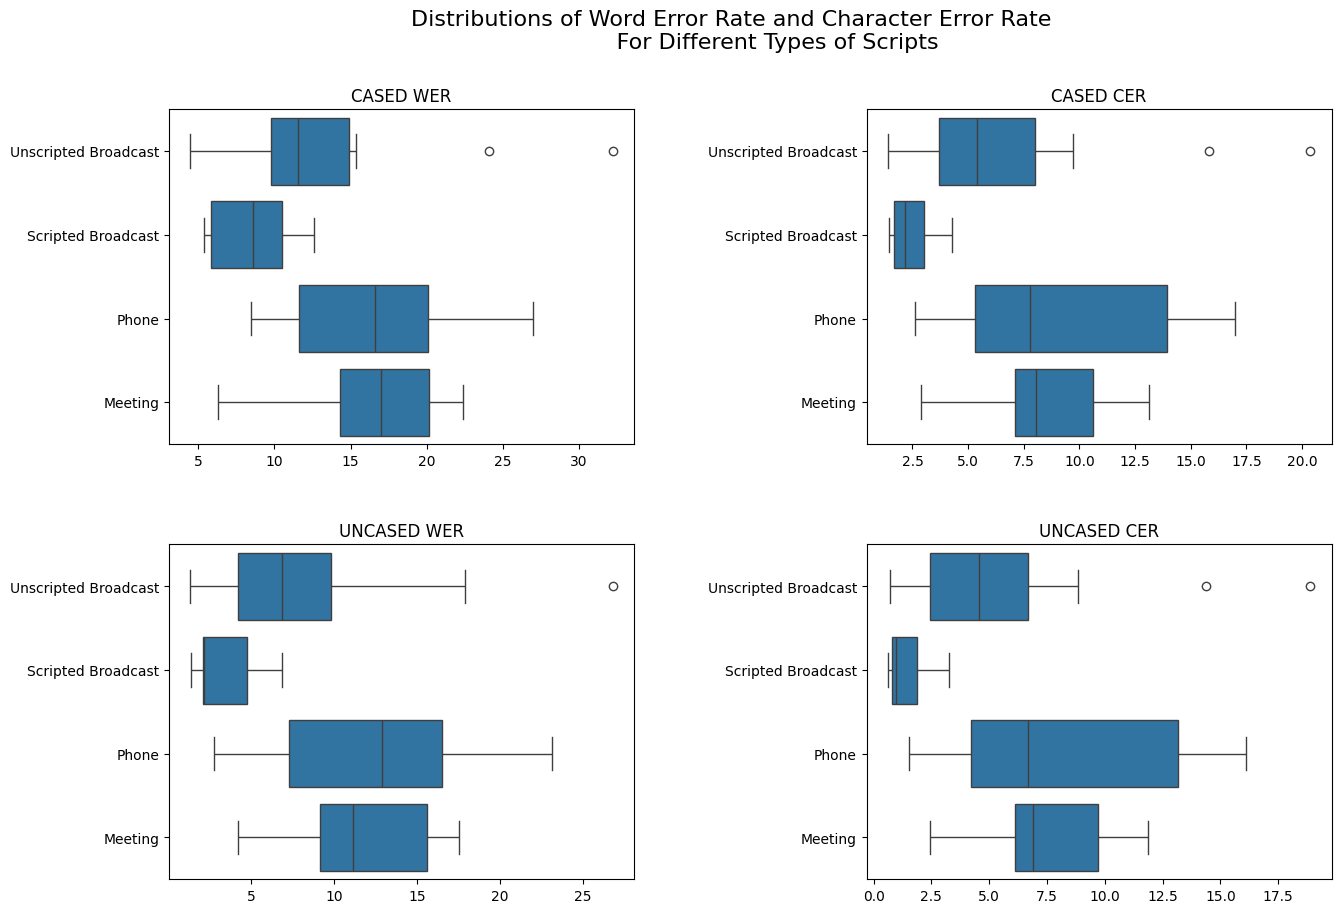

In [348]:
from collections import defaultdict
metric_cols = ['cased_wer_1', 'cased_cer_1', 'uncased_wer_1', 'uncased_cer_1']

# Using groupby to calculate WWER for each group
grouped_df = defaultdict(list)
grouped = df_evaluate.groupby('Tags')

for group_name, group_df in grouped:
    for col in metric_cols:
        if col.split("_")[1] == "cer":
            group_weights = group_df['letter_count'].tolist()
        else:
            group_weights = group_df['words_count'].tolist()
        group_wers = group_df[col].tolist()
        group_wwer = weighted_wer(group_weights, group_wers)
        grouped_df[group_name].append(group_wwer)

result_df = pd.DataFrame(dict(grouped_df), index=['cased_wwer_1', 'cased_wcer_1', 'uncased_wwer_1', 'uncased_wcer_1'])
display(result_df)

# Plotting distributions
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("""Distributions of Word Error Rate and Character Error Rate
             For Different Types of Scripts""", fontsize=16)
for ax, col in zip(axs.flatten(), metric_cols):
    sns.boxplot(data=df_evaluate, x=col, y='Tags', ax=ax)
    ax.set(title=f'{" ".join(col.split("_")[:2]).upper()}',
           xlabel='',
           ylabel='')
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()


* Scripted Broadcast is the easiest audio to transcribe with on average 1 letter mistake per 100 letters and 3 words per 100 in uncased transcript
* Unscripted Broadcast makes almost 9 mistakes for uncased words and every 6 letteres
* Phoncalls and meetings are harder for the model with quite high dependance of audio quality, the number of speekers 

Let's inspect the Unscripted data that was particullary hard.

In [349]:
df.loc[(df['cased_wer_1'] > 20) & (df['Tags']=='Unscripted Broadcast')]

,Id,Tags,Youtube Link,Reference Transcript,Title,Duration,Start,Availability,Amazon Transcript,words_count,letter_count,cased_wer_1,cased_cer_1,uncased_wer_1,uncased_cer_1
12,13,Unscripted Broadcast,https://www.youtube.com/watch?v=UtzQoq3Ln68,"Right now guys, start your web and let's talk ...",Podcast #185 - Drunk Stories,04:27,00:22,True,"Right now, guys, start your website that you a...",776,3931,32.22,20.38,26.80,18.9
13,14,Unscripted Broadcast,https://www.youtube.com/watch?v=r8NW2gszhbc,People are so mad about like monetization and ...,Off The Pill Podcast - Real Ghost Stories!? (f...,04:56,00:00,True,People are so mad about like monetization and ...,1052,5250,24.05,15.81,17.87,14.4


Both of them contain quite a few links that the model was unable to recognize, a music in the background, two people talking at the same time and topic specific words. Adding those words to model vocabluary potentially can improve predictions.

Overall performance

In [350]:
print(f"Cased Word Error Rate: {weighted_wer(df['words_count'].tolist(), df['cased_wer_1'].tolist())}")
print(f"Uncased Word Error Rate: {weighted_wer(df['words_count'].tolist(), df['uncased_wer_1'].tolist())}")
print(f"Cased Character Error Rate: {weighted_wer(df['letter_count'].tolist(), df['cased_cer_1'].tolist())}")
print(f"Uncased Character Error Rate: {weighted_wer(df['letter_count'].tolist(), df['uncased_cer_1'].tolist())}")

Cased Word Error Rate: 13.79
Uncased Word Error Rate: 9.04
Cased Character Error Rate: 6.86
Uncased Character Error Rate: 5.82


When we don't take into consideration punctuation (which is quite subjective) and case of the letters the model make 9 mistakes per 100 words and 6 mistakes per 100 letters. When we take into consideration also beginning of sentences and the names of objects or people the Word Error Rate equals 14/100 and Character Error Rate 7/100.

## Improvement of the model

Through analysis of missed words and comparison side by side the ground true scripts and transcription, there were visable some of the problems the model encountered:
* hyphened words but the sense stayed the same - this problem was tackled in the normalization step: sweet-lips -> sweet lips
* topic specific words like: Aesope's Fables, iCloud, bistables
* names of people taking part in the meeting: Chachki, Ladonna Hunton (here we need to note that the ground true can also be wrong unless the names were specified in the video description)
* names of organisations and products: Nyxio, Vioware
* spoken language phrases: heck, brat, cause, okay
* websites linkes: squarespace.com
The vocabulary will be created based on observations. We must remember that it grabs the phrases from the sample which will increase bias. Knowing the consumers of the developement we should either use the specific language used and create vocabulary or train the model with the set of text that is specific for consumers (the service is not included in the FreeTier).

For the purpose of this project we will pick up specific words that the model had problem with. Around 200 phrases were identified and stored in custom_vocab.csv

In [351]:
with open('custom_vocab.txt', 'r') as file:
    custom_vocab = [line.strip() for line in file.readlines()]
    
output_folder = 'transcriptionsimproved/'
transcribe_csv = 'data/transcriptimporved.csv'
version = "C"  
vocabulary_name = 'customvocab'
phrases = custom_vocab

In [352]:
check_assertions(input_folder, output_folder, version, format)

In [86]:
create_vocabulary(vocabulary_name, lang_code, transcribe_client, phrases)
job_count = transcribe_folder(s3_client, transcribe_client, bucket_name, 
              input_folder, output_folder, lang_code, format, version, vocabulary_name)
download_folder(s3_client, bucket_name, output_folder, job_count)
transcripts_to_csv(output_folder, transcribe_csv)

   Id                                  Amazon Transcript
0   1  Let's bring in Phil Mackie who is uh there at ...
1  10  Do you think Mr LeBron James will be patient e...
2  11  Where does James Harden rank as a player? Not ...
3  12  Welcome to the Undisputed podcast. I'm your ho...
4  13  Right now, guys, start your website that you a...


In [353]:
trans_improved = pd.read_csv("data/transcriptimporved.csv").rename(columns={'Amazon Transcript': 'Amazon Transcript Improved'})
df = pd.merge(df, trans_improved, on='Id')


In [354]:
# Calculating CER and WER
df['cased_wer_2'] = df.apply(lambda row: calculate_wer(row['Reference Transcript'], row['Amazon Transcript Improved'],
                                                       replacements, to_remove, True), axis=1)
df['cased_cer_2'] = df.apply(lambda row: calculate_cer(row['Reference Transcript'], row['Amazon Transcript Improved'],
                                                       replacements, to_remove, True), axis=1)
df['uncased_wer_2'] = df.apply(lambda row: calculate_wer(row['Reference Transcript'], row['Amazon Transcript Improved'],
                                                         replacements, to_remove, False), axis=1)
df['uncased_cer_2'] = df.apply(lambda row: calculate_cer(row['Reference Transcript'], row['Amazon Transcript Improved'],
                                                         replacements, to_remove, False), axis=1)

In [355]:
print(f"Cased Word Error Rate: {weighted_wer(df['words_count'].tolist(), df['cased_wer_2'].tolist())}")
print(f"Uncased Word Error Rate: {weighted_wer(df['words_count'].tolist(), df['uncased_wer_2'].tolist())}")
print(f"Cased Character Error Rate: {weighted_wer(df['letter_count'].tolist(), df['cased_cer_2'].tolist())}")
print(f"Uncased Character Error Rate: {weighted_wer(df['letter_count'].tolist(), df['uncased_cer_2'].tolist())}")

Cased Word Error Rate: 13.75
Uncased Word Error Rate: 9.02
Cased Character Error Rate: 6.91
Uncased Character Error Rate: 5.9


Previous output 

* Cased Word Error Rate: 13.79
* Uncased Word Error Rate: 9.04
* Cased Character Error Rate: 6.86
* Uncased Character Error Rate: 5.82

Let's see how many phrases from custom vocabulary used in the transcript and what is the actual size of the corpus.

In [356]:
result_string = ' '.join(df['Amazon Transcript Improved'].tolist())
count = 0
for phrase in phrases:
    if phrase in result_string:
        count += 1
print(f'The transcribtion jobs were enriched by {count} phrases from custom vocabulary.')
print(f'Number of words in the corpus: {df["words_count"].sum()}')

The transcribtion jobs were enriched by 108 phrases from custom vocabulary.
Number of words in the corpus: 36736


In [381]:
for i in df['Id'].tolist():
    y_hat = clean_text(df.loc[df['Id']==i]['Amazon Transcript Improved'].values[0], replacements, to_remove, False)
    y = clean_text(df.loc[df['Id']==i]['Reference Transcript'].values[0], replacements, to_remove, False)
    common, missing, extra = compare_words(y.split(), y_hat.split())
    print_to_width(f"{i}: {missing}", 160)


1: {'wants', 'brands', 'audiences', 'divisions', 'did', 'mercurial', 'noticed', 'coordinated', 'mast', 'minibuses', 'vips', 'residence', 'cabinets', 'hustle', '
cant', '10s', 'joes', 'too'}

2: {'cavern', 'luang', 'set', 'd', 'tham', '9th', 'under'}

3: {'leave', 'gotta', 'beginning', 'very', 'hers', 'by', 'character', 'shoes', 'cause', 'strong', 'sure', 'clothes', 'into'}

4: {'em', 'pro', 'yes', 'whe', 'health', 'choice'}

5: {'rodgers', 'rules', 'crimin', 'happening', 'your', 'fourteenth', 'berger', 'thetre', 'capital', 'nineteen', 'such', 'like', 'im'}

6: {'denouement', 'acc', 'realize', 'forum', 'maker', 'thatll', 'report', 'germanys', 'keep'}

7: {'good', 'lot', 'set', 'gav', 'placement', 'coach', 'stopped', 'probably', 'apparently', 'hitch', 'paris', 'shove', 'really', 'wilton', 'lier', 'onto', 'goal
', 'wouldve', 'perišić', 'shouldve', 'keeper', 'someone'}

8: {'horfored', 'surpri', 'suped', 'bostons', 'happen', 'scorers', 'develop', 'kuzmo', 'dudes', 'bergie', 'modern', 'post

In [383]:
y_hat = clean_text(df.loc[df['Id']==13]['Amazon Transcript Improved'].values[0], replacements, to_remove, False)
y = clean_text(df.loc[df['Id']==13]['Reference Transcript'].values[0], replacements, to_remove, False)
print_centered_columns(['Reference Transcript', 'Amazon Transcript Improved'], width=80)
show_comparison(y, y_hat, width=80, sidebyside=True, compact=False)

|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|                              Reference Transcript                              |                           Amazon Transcript Improved                             |
|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
right now guys start your web and lets talk about _______ ____ ___ ______ ____   | right now guys start your ___ ___ ____ ____ _____ website that you always want   | 
__ _____ __ going to sqarespacecomjennajulien _________________________ save 10  | to start by going to ________________________ squarespacecomjennajulien save 10  | 
of your first purchase of a website or domain squarespace has 247 __ _ customer  | of your first purchase of a website or domain squarespace has ___ 24 7 customer  | 
s

With an easy operation let's see how many of the words from custom vocabulary was included in the improved transcription.

## Conclusions

* just above half of the phrases were used in the transcript
* WER improved slightly while CER worsened slightly
* for web addresses using table based on the given cv-temple could be more useful as the specified once didn't brought any value
* for names using International Phonetic Alphabet could be more beneficial although we shouldn't be overly confident about the ground true names recollection as seen on the basketballers example
* there are still some problems with numbers and inconsistencies in how the model and human write them down
* some accronymes were picked up correctly as some not- the correct once were the once that are read as a word and the incorrect once were the once that are spelled out

## Imoprovements:

* checking the performance on custom vocabulary table with IPA given by ex. https://www.englishtools.org/en/convert-english-words-into-ipa-phonetic-alphabet and creating new vocabulary- the transcriptions in the free tier cover only 60min per month in our dataset we have around 230min, one transcription job for that dataset costs $5.52 (0.024$/min)
* collecting field specific corpus of data and retraining the model -> not applicable with the dataset we have
* using the noise reduction with library like noisereduce